# Description of Melbourne Dataset

1. [Load Data](#1.-Load-Data)
1. [Compute POI Statistics DataFrame](#2.-Compute-POI-Statistics-DataFrame)
 1. [Compute POI Visit Statistics](#2.1-Compute-POI-Visit-Statistics)
 1. [Visualise & Save POIs](#2.2-Visualise-&-Save-POIs)
1. [POI vs Photo](#3.-POI-vs-Photo)
 1. [POIs with NO Visits](#3.1-POIs-with-NO-Visits)
 1. [Photo Clusters without Corresponding POIs](#3.2-Photo-Clusters-without-Corresponding-POIs)
1. [Compute Trajectories](#4.-Compute-Trajectories)
1. [Recommendation via POI Ranking](#5.-Recommendation-via-POI-Ranking)
 1. [POI Features for Ranking](#5.1-POI-Features-for-Ranking)
 1. [Ranking POIs using rankSVM](#5.4-Ranking-POIs-using-rankSVM)
1. [Factorised Transition Probabilities](#6.-Factorised-Transition-Probabilities)
 1. [POI Features for Factorisation](#6.1-POI-Features-for-Factorisation)
 1. [Transition Matrix between POIs](#6.7-Transition-Matrix-between-POIs)
 1. [Visualise Transition Matrix](#6.8-Visualise-Transition-Matrix)
 1. [Visualise Transitions of Specific POIs](#6.9-Visualise-Transitions-of-Specific-POIs)
1. [Recommendation Results Comparison & Visualisation](#7.-Recommendation-Results-Comparison-&-Visualisation)
 1. [Choose an Example Trajectory](#7.1-Choose-an-Example-Trajectory)
 1. [Recommendation by POI Popularity](#7.2-Recommendation-by-POI-Popularity)
 1. [Recommendation by POI Rankings](#7.3-Recommendation-by-POI-Rankings)
 1. [Recommendation by Transition Probabilities](#7.4-Recommendation-by-Transition-Probabilities)
1. [Disclaimer](#8.-Disclaimer)
 1. [Problems of Trajectory Construction](#8.1-Problems-of-Trajectory-Construction)
 1. [Example of Terrible Trajectories](#8.2-Example-of-Terrible-Trajectories)
 1. [Limitations of Google Maps and Nationalmaps](#8.3-Limitations-of-Google-Maps-and-Nationalmaps)

<a id='sec1'></a>

In [1]:
% matplotlib inline

import os, sys, time, pickle, tempfile
import math, random, itertools
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from scipy.misc import logsumexp

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from scipy.linalg import kron

from fastkml import kml, styles
from shapely.geometry import Point, LineString

import pulp

In [2]:
RANK_C = 10  # regularisation parameter for rankSVM
BIN_CLUSTER = 5  # Number of bins/clusters for discritizing POI features
ranksvm_dir = '$HOME/work/ranksvm'

In [243]:
data_dir = '../data'
fpoi = os.path.join(data_dir, 'poi-Melb-all.csv')
fvisits = os.path.join(data_dir, 'userVisits-Melb.csv')
fphotos = os.path.join(data_dir, 'Melb_photos_bigbox.csv')

# 1. Load Data

Load POI/Trajectory data from file.

## 1.1 Load POI Data

In [4]:
poi_all = pd.read_csv(fpoi)
poi_all.set_index('poiID', inplace=True)
#poi_all.head()

In [5]:
poi_df = poi_all.copy()
poi_df.drop('poiURL', axis=1, inplace=True)
poi_df.rename(columns={'poiName':'Name', 'poiTheme':'Category', 'poiLat':'Latitude', 'poiLon':'Longitude'}, \
              inplace=True)
poi_df.head()

,Name,Category,Latitude,Longitude
poiID,,,,
0,Arts Precinct,City precincts,-37.82167,144.96778
1,Docklands,City precincts,-37.81700,144.94600
2,Government Precinct,City precincts,-37.81190,144.97300
3,Little Italy,City precincts,-37.79972,144.96694
4,RMIT City,City precincts,-37.80778,144.96333


## 1.2 Load Trajectory Data

In [6]:
visits = pd.read_csv(fvisits, sep=';')
#visits.head()

In [7]:
visits.drop(['poiTheme', 'poiFreq'], axis=1, inplace=True)
visits.rename(columns={'seqID':'trajID'}, inplace=True)
visits.head()

,photoID,userID,dateTaken,poiID,trajID
0,9588963220,67774014@N00,1377408461,8,3333
1,703949177,79925938@N00,1183135485,20,3975
2,775049707,79925938@N00,1183823546,18,3977
3,8687823797,35558720@N03,1364043697,25,1487
4,2676185,79925938@N00,1104369016,71,3919


# 2. Compute POI Statistics DataFrame

## 2.1 Compute POI Visit Statistics

Compute the number of photos associated with each POI.

In [8]:
poi_photo = visits[['photoID', 'poiID']].copy().groupby('poiID').agg(np.size)
poi_photo.rename(columns={'photoID':'#photos'}, inplace=True)
poi_photo.head()

,#photos
poiID,
0,102
1,139
2,304
3,138
4,349


Compute the visit duration at each POI.

In [9]:
poi_duration = visits[['dateTaken', 'poiID', 'trajID']].copy().groupby(['trajID', 'poiID']).agg([np.min, np.max])
poi_duration.columns = poi_duration.columns.droplevel()
poi_duration.rename(columns={'amin':'arrivalTime', 'amax':'departureTime'}, inplace=True)
poi_duration.reset_index(inplace=True)
poi_duration['poiDuration'] = poi_duration['departureTime'] - poi_duration['arrivalTime']
poi_duration.head()

,trajID,poiID,arrivalTime,departureTime,poiDuration
0,0,25,1226726126,1226726126,0
1,1,58,1205332532,1205332541,9
2,1,66,1205342722,1205342729,7
3,2,59,1205374109,1205374109,0
4,3,58,1205417265,1205417265,0


**Filtering out zero visit duration at POI**, otherwise many medians of duration will be zero.

In [10]:
#poi_duration = poi_duration[poi_duration['poiDuration'] > 0]

Compute the median and summation of POI visit duration.

In [11]:
poi_duration_stats = poi_duration[['poiID', 'poiDuration']].copy().groupby('poiID').agg([np.median, np.sum])
poi_duration_stats.columns = poi_duration_stats.columns.droplevel()
poi_duration_stats.rename(columns={'median':'medianDuration(sec)', 'sum':'totalDuration(sec)'}, inplace=True)
poi_duration_stats.head()

,medianDuration(sec),totalDuration(sec)
poiID,,
0,0.0,24600
1,0.0,42491
2,0.0,141155
3,0.0,61945
4,0.0,137382


Compute the number of visits at each POI by all users and by distinct users.  
**NOTE: we assume NO loops/subtours appear in trajectories**, 
so a specific user would visit a certain POI in a specific trajectory at most once.

In [12]:
poi_visits = visits[['userID', 'trajID', 'poiID', 'photoID']].copy().groupby(['userID','trajID','poiID']).agg(np.size)
poi_visits.reset_index(inplace=True)
poi_visits.rename(columns={'photoID':'#photosAtPOIInTraj'}, inplace=True)
poi_visits.head()

,userID,trajID,poiID,#photosAtPOIInTraj
0,10058801@N06,0,25,1
1,10087938@N02,1,58,2
2,10087938@N02,1,66,2
3,10087938@N02,2,59,1
4,10087938@N02,3,58,1


In [13]:
poi_visits_stats = poi_visits[['userID', 'poiID']].copy().groupby('poiID').agg([pd.Series.nunique, np.size])
poi_visits_stats.columns = poi_visits_stats.columns.droplevel()
poi_visits_stats.rename(columns={'nunique':'#distinctUsers', 'size':'#visits'}, inplace=True)
poi_visits_stats.head()

,#distinctUsers,#visits
poiID,,
0,64,73
1,39,52
2,83,116
3,44,54
4,50,84


Copy visit statistics to POI dataframe.

In [14]:
poi_df['#photos'] = 0
poi_df['#visits'] = 0
poi_df['#distinctUsers'] = 0
poi_df['medianDuration(sec)'] = 0.0
poi_df['totalDuration(sec)'] = 0.0

In [15]:
poi_df.loc[poi_photo.index, '#photos'] = poi_photo['#photos']
poi_df.loc[poi_visits_stats.index, '#visits'] = poi_visits_stats['#visits']
poi_df.loc[poi_visits_stats.index, '#distinctUsers'] = poi_visits_stats['#distinctUsers']
poi_df.loc[poi_duration_stats.index, 'medianDuration(sec)'] = poi_duration_stats['medianDuration(sec)']
poi_df.loc[poi_duration_stats.index, 'totalDuration(sec)'] = poi_duration_stats['totalDuration(sec)']
poi_df.head()

,Name,Category,Latitude,Longitude,#photos,#visits,#distinctUsers,medianDuration(sec),totalDuration(sec)
poiID,,,,,,,,,
0,Arts Precinct,City precincts,-37.82167,144.96778,102,73,64,0.0,24600.0
1,Docklands,City precincts,-37.81700,144.94600,139,52,39,0.0,42491.0
2,Government Precinct,City precincts,-37.81190,144.97300,304,116,83,0.0,141155.0
3,Little Italy,City precincts,-37.79972,144.96694,138,54,44,0.0,61945.0
4,RMIT City,City precincts,-37.80778,144.96333,349,84,50,0.0,137382.0


## 2.2 Visualise & Save POIs

Visualise POI on map: Simply import the above CSV file in Google Maps (Google Drive -> NEW -> More -> Google My Maps), an example of this POI dataframe shown on map is available [here](https://drive.google.com/open?id=1bY5XN1rQMzHWgqCw45OLCNoackA&usp=sharing).

To sort POIs according to one attribute (e.g. #photos) in Google Maps, click the option icon at the upper right corner of the layer, then click "Open data table", a data table will pop-up, click the column of interest (e.g. #photos), then click "Sort A->Z" to sort POIs according to that attribute (e.g. #photos) in ascending order.

Save POI dataframe to CSV file.

In [16]:
#poi_file = os.path.join(data_dir, 'poi_df.csv')
#poi_df.to_csv(poi_file, index=True)

# 3. POI vs Photo

## 3.1 POIs with NO Visits

In [17]:
poi_df[poi_df['#visits'] < 1]

,Name,Category,Latitude,Longitude,#photos,#visits,#distinctUsers,medianDuration(sec),totalDuration(sec)
poiID,,,,,,,,,
54,Flemington Racecourse,Sports stadiums,-37.79028,144.91250,0,0,0,0.0,0.0
64,Royal Melbourne Golf Club,Sports stadiums,-37.97000,145.03000,0,0,0,0.0,0.0
87,Yarra River,Transport,-37.85194,144.90833,0,0,0,0.0,0.0


## 3.2 Photo Clusters without Corresponding POIs

TODO: A map with a cluster of photos at some place in Melbourne, given that NO geo-coordinates were provided in its Wikipedia page.  
A popular place needs to be provided!

# 4. Compute Trajectories

## 4.1 Trajectories Data

Compute trajectories using POI visiting records, **assuming NO loops/subtours in trajectories.**

In [18]:
traj_all = visits[['userID', 'trajID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'trajID', 'poiID'])\
           .agg([np.min, np.max, np.size])
traj_all.columns = traj_all.columns.droplevel()
traj_all.reset_index(inplace=True)
traj_all.rename(columns={'amin':'startTime', 'amax':'endTime', 'size':'#photo'}, inplace=True)

In [19]:
traj_len = traj_all[['userID', 'trajID', 'poiID']].copy().groupby(['userID', 'trajID']).agg(np.size)
traj_len.reset_index(inplace=True)
traj_len.rename(columns={'poiID':'trajLen'}, inplace=True)

In [20]:
traj_all = pd.merge(traj_all, traj_len, on=['userID', 'trajID'])
traj_all['poiDuration'] = traj_all['endTime'] - traj_all['startTime']
traj_all.head(10)

,userID,trajID,poiID,startTime,endTime,#photo,trajLen,poiDuration
0,10058801@N06,0,25,1226726126,1226726126,1,1,0
1,10087938@N02,1,58,1205332532,1205332541,2,2,9
2,10087938@N02,1,66,1205342722,1205342729,2,2,7
3,10087938@N02,2,59,1205374109,1205374109,1,1,0
4,10087938@N02,3,58,1205417265,1205417265,1,1,0
5,10087938@N02,4,58,1205508764,1205538412,3,2,29648
6,10087938@N02,4,59,1205512653,1205514882,22,2,2229
7,10087938@N02,5,59,1205575764,1205595114,4,1,19350
8,10087938@N02,6,59,1205625724,1205641382,2,1,15658
9,10087938@N02,7,58,1205812892,1205812892,1,1,0


## 4.2 Utility Functions

Extract trajectory, i.e., a list of POIs, considering loops/subtours.

In [21]:
def extract_traj_withloop(tid, visits):
    """Compute trajectories info, taking care of trajectories that contain sub-tours"""
    traj_df = visits[visits['trajID'] == tid].copy()
    traj_df.sort_values(by='dateTaken', ascending=True, inplace=True)
    traj = []
    for ix in traj_df.index:
        poi = traj_df.loc[ix, 'poiID']
        if len(traj) == 0:
            traj.append(poi)
        else:
            if poi != traj[-1]:
                traj.append(poi)
    return traj

Extract trajectory, i.e., a list of POIs, assuming NO considering loops/subtours exist.

In [22]:
def extract_traj(tid, traj_all):
    traj = traj_all[traj_all['trajID'] == tid].copy()
    traj.sort_values(by=['startTime'], ascending=True, inplace=True)
    return traj['poiID'].tolist()

Counting the number of trajectories with loops/subtours.

In [23]:
loopcnt = 0
for tid_ in visits['trajID'].unique():
    traj_ = extract_traj_withloop(tid_, visits)
    if len(traj_) != len(set(traj_)):
        #print(traj_)
        loopcnt += 1
print('Number of trajectories with loops/subtours:', loopcnt)

Number of trajectories with loops/subtours: 211


Compute POI properties, e.g., popularity, total number of visit, average visit duration.

In [24]:
def calc_poi_info(trajid_list, traj_all, poi_all):
    assert(len(trajid_list) > 0)
    # to allow duplicated trajid
    poi_info = traj_all[traj_all['trajID'] == trajid_list[0]][['poiID', 'poiDuration']].copy() 
    for i in range(1, len(trajid_list)):
        traj = traj_all[traj_all['trajID'] == trajid_list[i]][['poiID', 'poiDuration']]
        poi_info = poi_info.append(traj, ignore_index=True)
    
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration', 'size':'nVisit'}, inplace=True)
    poi_info.set_index('poiID', inplace=True) 
    poi_info['poiCat'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    
    # POI popularity: the number of distinct users that visited the POI
    pop_df = traj_all[traj_all['trajID'].isin(trajid_list)][['poiID', 'userID']].copy()
    pop_df = pop_df.groupby('poiID').agg(pd.Series.nunique)
    pop_df.rename(columns={'userID':'nunique'}, inplace=True)
    poi_info['popularity'] = pop_df.loc[poi_info.index, 'nunique']
    
    return poi_info.copy()

Compute the F1 score for recommended trajectory, **assuming NO loops/subtours in trajectories.**

In [25]:
def calc_F1(traj_act, traj_rec):
    '''Compute recall, precision and F1 for recommended trajectories'''
    assert(isinstance(noloop, bool))
    assert(len(traj_act) > 0)
    assert(len(traj_rec) > 0)
    
    intersize = len(set(traj_act) & set(traj_rec))
    recall = intersize / len(traj_act)
    precision = intersize / len(traj_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

Compute distance between two POIs using [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance).

In [26]:
def calc_dist_vec(longitudes1, latitudes1, longitudes2, latitudes2):
    """Calculate the distance (unit: km) between two places on earth, vectorised"""
    # convert degrees to radians
    lng1 = np.radians(longitudes1)
    lat1 = np.radians(latitudes1)
    lng2 = np.radians(longitudes2)
    lat2 = np.radians(latitudes2)
    radius = 6371.0088 # mean earth radius, en.wikipedia.org/wiki/Earth_radius#Mean_radius

    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlng = np.fabs(lng1 - lng2)
    dlat = np.fabs(lat1 - lat2)
    dist =  2 * radius * np.arcsin( np.sqrt( 
                (np.sin(0.5*dlat))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(0.5*dlng))**2 ))
    return dist

Distance between POIs.

In [27]:
POI_DISTMAT = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.float), \
                           index=poi_all.index, columns=poi_all.index)

In [28]:
for ix in poi_all.index:
    POI_DISTMAT.loc[ix] = calc_dist_vec(poi_all.loc[ix, 'poiLon'], \
                                        poi_all.loc[ix, 'poiLat'], \
                                        poi_all['poiLon'], \
                                        poi_all['poiLat'])

In [29]:
trajid_set_all = sorted(traj_all['trajID'].unique().tolist())

In [30]:
poi_info_all = calc_poi_info(trajid_set_all, traj_all, poi_all)

Filtering out POI visits with 0 duration.

In [31]:
zero_duration = poi_info_all[poi_info_all['avgDuration'] < 1]
zero_duration

,avgDuration,nVisit,poiCat,poiLon,poiLat,popularity
poiID,,,,,,
83,0.0,1,Transport,144.84333,-37.67333,1


In [32]:
print(traj_all.shape)
traj_all = traj_all[traj_all['poiID'].isin(set(poi_info_all.index) - set(zero_duration.index))]
print(traj_all.shape)

(7246, 8)
(7245, 8)


Dictionary maps every trajectory ID to the actual trajectory.

In [33]:
traj_dict = dict()

In [34]:
for trajid in trajid_set_all:
    traj = extract_traj(trajid, traj_all)
    assert(trajid not in traj_dict)
    traj_dict[trajid] = traj

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [35]:
QUERY_ID_DICT = dict()  # (start, end, length) --> qid

In [36]:
keys = [(traj_dict[x][0], traj_dict[x][-1], len(traj_dict[x])) \
        for x in sorted(traj_dict.keys()) if len(traj_dict[x]) > 2]
cnt = 0
for key in keys:
    if key not in QUERY_ID_DICT:   # (start, end, length) --> qid
        QUERY_ID_DICT[key] = cnt
        cnt += 1

In [37]:
print('#traj in total:', len(trajid_set_all))
print('#traj (length > 2):', traj_all[traj_all['trajLen'] > 2]['trajID'].unique().shape[0])
print('#query tuple:', len(QUERY_ID_DICT))

#traj in total: 5106
#traj (length > 2): 442
#query tuple: 415


# 5. Recommendation via POI Ranking

## 5.1 POI Features for Ranking

POI Features used for ranking:
1. `popularity`: POI popularity, i.e., the number of distinct users that visited the POI
1. `nVisit`: the total number of visit by all users
1. `avgDuration`: average POI visit duration
1. `sameCatStart`: 1 if POI category is the same as that of `startPOI`, -1 otherwise
1. `sameCatEnd`: 1 if POI category is the same as that of `endPOI`, -1 otherwise
1. `distStart`: distance (haversine formula) from `startPOI`
1. `distEnd`: distance from `endPOI`
1. `seqLen`: trajectory length (copy from query)
1. `diffPopStart`: difference in POI popularity from `startPOI`
1. `diffPopEnd`: difference in POI popularity from `endPOI`
1. `diffNVisitStart`: difference in the total number of visit from `startPOI`
1. `diffNVisitEnd`: difference in the total number of visit from `endPOI`
1. `diffDurationStart`: difference in average POI visit duration from the actual duration spent at `startPOI`
1. `diffDurationEnd`: difference in average POI visit duration from the actual duration spent at `endPOI`

In [38]:
DF_COLUMNS = ['poiID', 'label', 'queryID', 'popularity', 'nVisit', 'avgDuration', \
              'sameCatStart', 'sameCatEnd', 'distStart', 'distEnd', 'trajLen', 'diffPopStart', \
              'diffPopEnd', 'diffNVisitStart', 'diffNVisitEnd', 'diffDurationStart', 'diffDurationEnd']

## 5.2 Training DataFrame

Training data are generated as follows:
1. each input tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$ form a `query` (in IR terminology).
1. the label of a specific POI is the number of presence of that POI in a specific `query`, excluding the presence as $\text{startPOI}$ or $\text{endPOI}$.
1. for each `query`, the label of all absence POIs from trajectories of that `query` in training set got a label 0.

The dimension of training data matrix is `#(qid, poi)` by `#feature`.

In [39]:
def gen_train_subdf(poi_id, query_id_set, poi_info, query_id_rdict):
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    df_ = pd.DataFrame(data=np.zeros((len(query_id_set), len(columns)), dtype=np.float), columns=columns)
    
    pop = poi_info.loc[poi_id, 'popularity']; nvisit = poi_info.loc[poi_id, 'nVisit']
    cat = poi_info.loc[poi_id, 'poiCat']; duration = poi_info.loc[poi_id, 'avgDuration']
    
    for j in range(len(query_id_set)):
        qid = query_id_set[j]
        assert(qid in query_id_rdict) # qid --> (start, end, length)
        (p0, pN, trajLen) = query_id_rdict[qid]
        idx = df_.index[j]
        df_.loc[idx, 'poiID'] = poi_id
        df_.loc[idx, 'queryID'] = qid
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi_id, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi_id, pN]
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
        
    return df_

In [40]:
def gen_train_df(trajid_list, traj_dict, poi_info, n_jobs=-1):
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    train_trajs = [traj_dict[x] for x in trajid_list if len(traj_dict[x]) > 2]
    
    qid_set = sorted(set([query_id_dict[(t[0], t[-1], len(t))] for t in train_trajs]))
    poi_set = set()
    for tr in train_trajs:
        poi_set = poi_set | set(tr)
    
    #qid_poi_pair = list(itertools.product(qid_set, poi_set)) # Cartesian product of qid_set and poi_set
    #df_ = pd.DataFrame(data=np.zeros((len(qid_poi_pair), len(columns)), dtype= np.float), columns=columns)
    
    query_id_rdict = dict()
    for k, v in query_id_dict.items(): 
        query_id_rdict[v] = k  # qid --> (start, end, length)
    
    train_df_list = Parallel(n_jobs=n_jobs)\
                            (delayed(gen_train_subdf)(poi, qid_set, poi_info, query_id_rdict) \
                             for poi in poi_set)
                        
    assert(len(train_df_list) > 0)
    df_ = train_df_list[0]
    for j in range(1, len(train_df_list)):
        df_ = df_.append(train_df_list[j], ignore_index=True)            
        
    # set label
    df_.set_index(['queryID', 'poiID'], inplace=True)
    for t in train_trajs:
        qid = query_id_dict[(t[0], t[-1], len(t))]
        for poi in t[1:-1]:  # do NOT count if the POI is startPOI/endPOI
            df_.loc[(qid, poi), 'label'] += 1

    df_.reset_index(inplace=True)
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

## 5.3 Test DataFrame

Test data are generated the same way as training data, except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).
The reported accuracy (by `svm-predict` command) is meaningless as it is calculated based on these labels.

The dimension of training data matrix is `#poi` by `#feature` with one specific `query`, i.e. tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$.

In [41]:
def gen_test_df(startPOI, endPOI, nPOI, poi_info):
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    key = (p0, pN, trajLen) = (startPOI, endPOI, nPOI)
    assert(key in query_id_dict)
    assert(p0 in poi_info.index)
    assert(pN in poi_info.index)
    
    df_ = pd.DataFrame(data=np.zeros((poi_info.shape[0], len(columns)), dtype= np.float), columns=columns)
    poi_list = sorted(poi_info.index)
    
    qid = query_id_dict[key]
    df_['queryID'] = qid
    df_['label'] = np.random.rand(df_.shape[0]) # label for test data is arbitrary according to libsvm FAQ

    for i in range(df_.index.shape[0]):
        poi = poi_list[i]
        lon = poi_info.loc[poi, 'poiLon']; lat = poi_info.loc[poi, 'poiLat']
        pop = poi_info.loc[poi, 'popularity']; nvisit = poi_info.loc[poi, 'nVisit']
        cat = poi_info.loc[poi, 'poiCat']; duration = poi_info.loc[poi, 'avgDuration']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi 
        df_.loc[idx, 'popularity'] = pop
        df_.loc[idx, 'nVisit'] = nvisit
        df_.loc[idx, 'avgDuration'] = duration
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi, pN]
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

Generate a string for a training/test data frame.

In [42]:
def gen_data_str(df_, df_columns=DF_COLUMNS):
    columns = df_columns[1:].copy()  # get rid of 'poiID'
    for col in columns:
        assert(col in df_.columns)
        
    lines = []
    for idx in df_.index:
        slist = [str(df_.loc[idx, 'label'])]
        slist.append(' qid:')
        slist.append(str(int(df_.loc[idx, 'queryID'])))
        for j in range(2, len(columns)):
            slist.append(' ')
            slist.append(str(j-1))
            slist.append(':')
            slist.append(str(df_.loc[idx, columns[j]]))
        slist.append('\n')
        lines.append(''.join(slist))
    return ''.join(lines)

## 5.4 Ranking POIs using rankSVM

RankSVM implementation in [libsvm.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip) or [liblinear.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/liblinear-ranksvm-1.95.zip), please read `README.ranksvm` in the zip file for installation instructions.

Use [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to convert ranking scores to a probability distribution.

In [43]:
def softmax(x):
    x1 = x.copy()
    x1 -= np.max(x1)  # numerically more stable, REF: http://cs231n.github.io/linear-classify/#softmax
    expx = np.exp(x1)
    return expx / np.sum(expx, axis=0) # column-wise sum

Below is a python wrapper of the `svm-train` or `train` and `svm-predict` or `predict` commands of rankSVM with ranking probabilities $P(p_i \lvert (p_s, p_e, len))$ computed using [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [44]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, useLinear=True, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        
        self.bin_train = 'svm-train'
        self.bin_predict = 'svm-predict'
        if useLinear:
            self.bin_train = 'train'
            self.bin_predict = 'predict'
        
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.fmodel is not None and os.path.exists(self.fmodel):
            os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('cost:', cost)
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        result = !$self.bin_dir/$self.bin_train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        os.unlink(ftrain)
        os.unlink(ftrain_scaled)        
        
    
    def predict(self, test_df):
        # predict ranking scores for the given feature matrix
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/$self.bin_predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df['poiID'].astype(np.int)
        poi_rank_df.set_index('poiID', inplace=True) # duplicated 'poiID' when evaluating training data
        #poi_rank_df['probability'] = softmax(poi_rank_df['rank'])  # softmax
        
        # remove test file and prediction file
        os.unlink(ftest)
        os.unlink(ftest_scaled)
        os.unlink(fpredict)
        
        return poi_rank_df

# 6. Factorised Transition Probabilities

## 6.1 POI Features for Factorisation

POI features used to factorise transition matrix of Markov Chain with POI features (vector) as states:
- Category of POI
- Popularity of POI (discritize with uniform log-scale bins, #bins=5 )
- The number of POI visits (discritize with uniform log-scale bins, #bins=5 )
- The average visit duration of POI (discritise with uniform log-scale bins, #bins= 5)
- The neighborhood relationship between POIs (clustering POI(lat, lon) using k-means, #clusters= 5)

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a number $k=1$.

In [45]:
def normalise_transmat(transmat_cnt):
    transmat = transmat_cnt.copy()
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        rowsum = np.sum(transmat.iloc[row] + 1)
        assert(rowsum > 0)
        transmat.iloc[row] = (transmat.iloc[row] + 1) / rowsum
    return transmat

POIs in training set.

In [46]:
poi_train = sorted(poi_info_all.index)

## 6.2 Transition Matrix between POI Cateogries

In [47]:
poi_cats = poi_all.loc[poi_train, 'poiTheme'].unique().tolist()
poi_cats.sort()
#poi_cats

In [48]:
def gen_transmat_cat(trajid_list, traj_dict, poi_info, poi_cats=poi_cats):
    transmat_cat_cnt = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                    columns=poi_cats, index=poi_cats)
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                cat1 = poi_info.loc[p1, 'poiCat']
                cat2 = poi_info.loc[p2, 'poiCat']
                transmat_cat_cnt.loc[cat1, cat2] += 1
    return normalise_transmat(transmat_cat_cnt)

In [49]:
gen_transmat_cat(trajid_set_all, traj_dict, poi_info_all)

,City precincts,Entertainment,Institutions,Parks and spaces,Public galleries,Shopping,Sports stadiums,Structures,Transport
City precincts,0.059259,0.059259,0.207407,0.118519,0.096296,0.148148,0.059259,0.148148,0.103704
Entertainment,0.043011,0.107527,0.086022,0.086022,0.043011,0.193548,0.021505,0.225806,0.193548
Institutions,0.063830,0.031915,0.188830,0.188830,0.015957,0.265957,0.013298,0.138298,0.093085
Parks and spaces,0.041322,0.030303,0.154270,0.151515,0.033058,0.126722,0.049587,0.236915,0.176309
Public galleries,0.114286,0.071429,0.128571,0.142857,0.057143,0.142857,0.028571,0.114286,0.200000
Shopping,0.057377,0.049180,0.229508,0.077869,0.010246,0.354508,0.008197,0.086066,0.127049
Sports stadiums,0.059524,0.107143,0.059524,0.202381,0.023810,0.071429,0.321429,0.047619,0.107143
Structures,0.053968,0.076190,0.107937,0.247619,0.028571,0.171429,0.025397,0.136508,0.152381
Transport,0.067340,0.043771,0.151515,0.185185,0.013468,0.185185,0.030303,0.202020,0.121212


## 6.3 Transition Matrix between POI Popularity Classes

In [50]:
poi_pops = poi_info_all.loc[poi_train, 'popularity']
#sorted(poi_pops.unique().tolist())

Discretize POI popularity with uniform log-scale bins.

In [51]:
expo_pop1 = np.log10(max(1, min(poi_pops)))
expo_pop2 = np.log10(max(poi_pops))
print(expo_pop1, expo_pop2)

0.0 2.4623979979


In [52]:
nbins_pop = BIN_CLUSTER
logbins_pop = np.logspace(np.floor(expo_pop1), np.ceil(expo_pop2), nbins_pop+1)
logbins_pop[0] = 0  # deal with underflow
if logbins_pop[-1] < poi_info_all['popularity'].max():
    logbins_pop[-1] = poi_info_all['popularity'].max() + 1
logbins_pop

array([    0.        ,     3.98107171,    15.84893192,    63.09573445,
         251.18864315,  1000.        ])

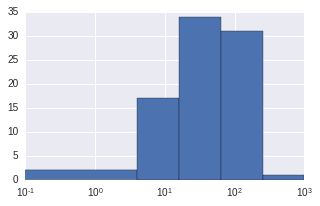

In [53]:
ax = pd.Series(poi_pops).hist(figsize=(5, 3), bins=logbins_pop)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [54]:
def gen_transmat_pop(trajid_list, traj_dict, poi_info, logbins_pop=logbins_pop):
    nbins = len(logbins_pop) - 1
    transmat_pop_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                    columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                pop1 = poi_info.loc[p1, 'popularity']
                pop2 = poi_info.loc[p2, 'popularity']
                pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
                transmat_pop_cnt.loc[pc1, pc2] += 1
    return normalise_transmat(transmat_pop_cnt), logbins_pop

In [55]:
gen_transmat_pop(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.166667,0.166667,0.333333,0.166667,0.166667
2,0.017544,0.175439,0.350877,0.421053,0.035088
3,0.002262,0.033937,0.316742,0.608597,0.038462
4,0.001350,0.025641,0.172065,0.715250,0.085695
5,0.005618,0.022472,0.095506,0.870787,0.005618


## 6.4 Transition Matrix between the Number of POI Visit Classes

In [56]:
poi_visits = poi_info_all.loc[poi_train, 'nVisit']
#sorted(poi_visits.unique().tolist())

Discretize the number of POI visit with uniform log-scale bins.

In [57]:
expo_visit1 = np.log10(max(1, min(poi_visits)))
expo_visit2 = np.log10(max(poi_visits))
print(expo_visit1, expo_visit2)

0.0 2.69108149212


In [58]:
nbins_visit = BIN_CLUSTER
logbins_visit = np.logspace(np.floor(expo_visit1), np.ceil(expo_visit2), nbins_visit+1)
logbins_visit[0] = 0  # deal with underflow
if logbins_visit[-1] < poi_info_all['nVisit'].max():
    logbins_visit[-1] = poi_info_all['nVisit'].max() + 1
logbins_visit

array([    0.        ,     3.98107171,    15.84893192,    63.09573445,
         251.18864315,  1000.        ])

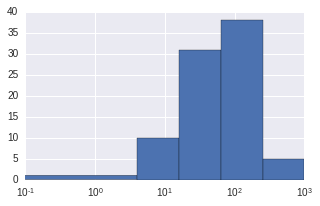

In [59]:
ax = pd.Series(poi_visits).hist(figsize=(5, 3), bins=logbins_visit)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [60]:
def gen_transmat_visit(trajid_list, traj_dict, poi_info, logbins_visit=logbins_visit):
    nbins = len(logbins_visit) - 1
    transmat_visit_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                      columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                visit1 = poi_info.loc[p1, 'nVisit']
                visit2 = poi_info.loc[p2, 'nVisit']
                vc1, vc2 = np.digitize([visit1, visit2], logbins_visit)
                transmat_visit_cnt.loc[vc1, vc2] += 1
    return normalise_transmat(transmat_visit_cnt), logbins_visit

In [61]:
gen_transmat_visit(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.038462,0.076923,0.346154,0.500000,0.038462
3,0.003448,0.027586,0.272414,0.562069,0.134483
4,0.000762,0.017517,0.121097,0.614623,0.246002
5,0.001883,0.007533,0.064030,0.651601,0.274953


## 6.5 Transition Matrix between POI Average Visit Duration Classes

In [62]:
poi_durations = poi_info_all.loc[poi_train, 'avgDuration']
#sorted(poi_durations.unique().tolist())

In [63]:
expo_duration1 = np.log10(max(1, min(poi_durations)))
expo_duration2 = np.log10(max(poi_durations))
print(expo_duration1, expo_duration2)

0.0 3.90794220593


In [64]:
nbins_duration = BIN_CLUSTER
logbins_duration = np.logspace(np.floor(expo_duration1), np.ceil(expo_duration2), nbins_duration+1)
logbins_duration[0] = 0  # deal with underflow
logbins_duration[-1] = np.power(10, expo_duration2+2)
logbins_duration

array([  0.00000000e+00,   6.30957344e+00,   3.98107171e+01,
         2.51188643e+02,   1.58489319e+03,   8.08988235e+05])

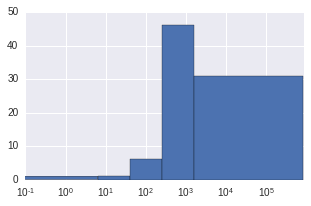

In [65]:
ax = pd.Series(poi_durations).hist(figsize=(5, 3), bins=logbins_duration)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [66]:
def gen_transmat_duration(trajid_list, traj_dict, poi_info, logbins_duration=logbins_duration):
    nbins = len(logbins_duration) - 1
    transmat_duration_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                         columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                d1 = poi_info.loc[p1, 'avgDuration']
                d2 = poi_info.loc[p2, 'avgDuration']
                dc1, dc2 = np.digitize([d1, d2], logbins_duration)
                transmat_duration_cnt.loc[dc1, dc2] += 1
    return normalise_transmat(transmat_duration_cnt), logbins_duration

In [67]:
gen_transmat_duration(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.166667,0.166667,0.166667,0.333333,0.166667
3,0.012658,0.012658,0.037975,0.582278,0.354430
4,0.000708,0.001416,0.043201,0.647309,0.307365
5,0.001508,0.001508,0.036199,0.686275,0.274510


## 6.6 Transition Matrix between POI Neighborhood Classes

KMeans in scikit-learn seems unable to use custom distance metric and no implementation of [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance), use Euclidean distance to approximate.

In [68]:
X = poi_all.loc[poi_train, ['poiLon', 'poiLat']]
nclusters = BIN_CLUSTER

In [69]:
kmeans = KMeans(n_clusters=nclusters)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [70]:
clusters = kmeans.predict(X)
#clusters
poi_clusters = pd.DataFrame(data=clusters, index=poi_train)
poi_clusters.index.name = 'poiID'
poi_clusters.rename(columns={0:'clusterID'}, inplace=True)
#poi_clusters

Scatter plot of POI coordinates with clustering results.

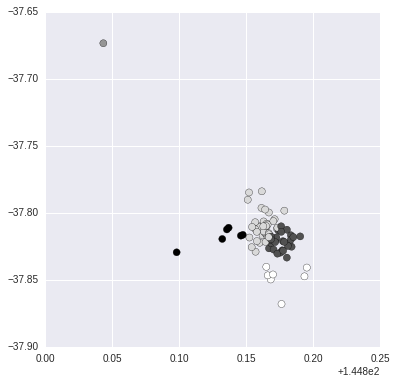

In [71]:
diff = poi_all.loc[poi_train, ['poiLon', 'poiLat']].max() - poi_all.loc[poi_train, ['poiLon', 'poiLat']].min()
ratio = diff['poiLon'] / diff['poiLat']
#ratio
height = 6; width = int(round(ratio)*height)
plt.figure(figsize=[width, height])
plt.scatter(poi_all.loc[poi_train, 'poiLon'], poi_all.loc[poi_train, 'poiLat'], c=clusters, s=50)

In [72]:
def gen_transmat_neighbor(trajid_list, traj_dict, poi_info, poi_clusters=poi_clusters):
    nclusters = len(poi_clusters['clusterID'].unique())
    transmat_neighbor_cnt = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                         columns=np.arange(nclusters), index=np.arange(nclusters))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                c1 = poi_clusters.loc[p1, 'clusterID']
                c2 = poi_clusters.loc[p2, 'clusterID']
                transmat_neighbor_cnt.loc[c1, c2] += 1
    return normalise_transmat(transmat_neighbor_cnt), poi_clusters

In [73]:
gen_transmat_neighbor(trajid_set_all, traj_dict, poi_info_all)[0]

,0,1,2,3,4
0,0.257143,0.514286,0.028571,0.171429,0.028571
1,0.012605,0.771709,0.000700,0.197479,0.017507
2,0.200000,0.200000,0.200000,0.200000,0.200000
3,0.013699,0.439878,0.001522,0.538813,0.006088
4,0.025000,0.600000,0.025000,0.150000,0.200000


## 6.7 Transition Matrix between POIs

Approximate transition probabilities (matrix) between different POI features (vector) using the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of individual transition matrix corresponding to each feature, i.e., POI category, POI popularity (discritized), POI average visit duration (discritized) and POI neighborhoods (clusters).

Deal with features without corresponding POIs and feature with more than one corresponding POIs. (*Before Normalisation*)
- For features without corresponding POIs, just remove the rows and columns from the matrix obtained by Kronecker product.
- For different POIs with the exact same feature, 
  - Let POIs with the same feature as a POI group,
  - The *incoming* **transition value (i.e., unnormalised transition probability)** of this POI group 
    should be divided uniformly among the group members, 
    *which corresponds to choose a group member uniformly at random in the incoming case*.
  - The *outgoing* transition value should be duplicated (i.e., the same) among all group members, 
    **as we were already in that group in the outgoing case**.
  - For each POI in the group, the allocation transition value of the *self-loop of the POI group* is similar to 
    that in the *outgoing* case, **as we were already in that group**, so just duplicate and then divide uniformly among 
    the transitions from this POI to other POIs in the same group, 
    *which corresponds to choose a outgoing transition uniformly at random from all outgoing transitions
    excluding the self-loop of this POI*.
- **Concretely**, for a POI group with $n$ POIs, 
    1. If the *incoming* transition value of POI group is $m_1$,
       then the corresponding *incoming* transition value for each group member is $\frac{m_1}{n}$.
    1. If the *outgoing* transition value of POI group is $m_2$,
       then the corresponding *outgoing* transition value for each group member is also $m_2$.
    1. If the transition value of *self-loop of the POI group* is $m_3$,
       then transition value of *self-loop of individual POIs* should be $0$,  
       and *other in-group transitions* with value $\frac{m_3}{n-1}$
       as the total number of outgoing transitions to other POIs in the same group is $n-1$ (excluding the self-loop),
       i.e. $n-1$ choose $1$.
       
**NOTE**: execute the above division before or after row normalisation will lead to the same result, *as the division itself does NOT change the normalising constant of each row (i.e., the sum of each row before normalising)*.

In [74]:
def gen_poi_transmat(trajid_list, poi_set, traj_dict, poi_info, debug=False):
    transmat_cat                        = gen_transmat_cat(trajid_list, traj_dict, poi_info)
    transmat_pop,      logbins_pop      = gen_transmat_pop(trajid_list, traj_dict, poi_info)
    transmat_visit,    logbins_visit    = gen_transmat_visit(trajid_list, traj_dict, poi_info)
    transmat_duration, logbins_duration = gen_transmat_duration(trajid_list, traj_dict, poi_info)
    transmat_neighbor, poi_clusters     = gen_transmat_neighbor(trajid_list, traj_dict, poi_info)

    # Kronecker product
    transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_visit.index, \
                                         transmat_duration.index, transmat_neighbor.index))
    transmat_value = transmat_cat.values
    for transmat in [transmat_pop, transmat_visit, transmat_duration, transmat_neighbor]:
        transmat_value = kron(transmat_value, transmat.values)
    transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
    
    poi_train = sorted(poi_set)
    feature_names = ['poiCat', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
    poi_features = pd.DataFrame(data=np.zeros((len(poi_train), len(feature_names))), \
                                columns=feature_names, index=poi_train)
    poi_features.index.name = 'poiID'
    poi_features['poiCat'] = poi_info.loc[poi_train, 'poiCat']
    poi_features['popularity'] = np.digitize(poi_info.loc[poi_train, 'popularity'], logbins_pop)
    poi_features['nVisit'] = np.digitize(poi_info.loc[poi_train, 'nVisit'], logbins_visit)
    poi_features['avgDuration'] = np.digitize(poi_info.loc[poi_train, 'avgDuration'], logbins_duration)
    poi_features['clusterID'] = poi_clusters.loc[poi_train, 'clusterID']
    
    # shrink the result of Kronecker product and deal with POIs with the same features
    poi_logtransmat = pd.DataFrame(data=np.zeros((len(poi_train), len(poi_train)), dtype=np.float), \
                                   columns=poi_train, index=poi_train)
    for p1 in poi_logtransmat.index:
        rix = tuple(poi_features.loc[p1])
        for p2 in poi_logtransmat.columns:
            cix = tuple(poi_features.loc[p2])
            value_ = transmat_feature.loc[(rix,), (cix,)]
            poi_logtransmat.loc[p1, p2] = value_.values[0, 0]
    
    # group POIs with the same features
    features_dup = dict()
    for poi in poi_features.index:
        key = tuple(poi_features.loc[poi])
        if key in features_dup:
            features_dup[key].append(poi)
        else:
            features_dup[key] = [poi]
    if debug == True:
        for key in sorted(features_dup.keys()):
            print(key, '->', features_dup[key])
            
    # deal with POIs with the same features
    for feature in sorted(features_dup.keys()):
        n = len(features_dup[feature])
        if n > 1:
            group = features_dup[feature]
            v1 = poi_logtransmat.loc[group[0], group[0]]  # transition value of self-loop of POI group
            
            # divide incoming transition value (i.e. unnormalised transition probability) uniformly among group members
            for poi in group:
                poi_logtransmat[poi] /= n
                
            # outgoing transition value has already been duplicated (value copied above)
            
            # duplicate & divide transition value of self-loop of POI group uniformly among all outgoing transitions,
            # from a POI to all other POIs in the same group (excluding POI self-loop)
            v2 = v1 / (n - 1)
            for pair in itertools.permutations(group, 2):
                poi_logtransmat.loc[pair[0], pair[1]] = v2
                            
    # normalise each row
    for p1 in poi_logtransmat.index:
        poi_logtransmat.loc[p1, p1] = 0
        rowsum = poi_logtransmat.loc[p1].sum()
        assert(rowsum > 0)
        logrowsum = np.log10(rowsum)
        for p2 in poi_logtransmat.columns:
            if p1 == p2:
                poi_logtransmat.loc[p1, p2] = -np.inf  # deal with log(0) explicitly
            else:
                poi_logtransmat.loc[p1, p2] = np.log10(poi_logtransmat.loc[p1, p2]) - logrowsum
    
    poi_transmat = np.power(10, poi_logtransmat)
    return poi_transmat

In [75]:
poi_transmat = gen_poi_transmat(trajid_set_all, set(poi_info_all.index), traj_dict, poi_info_all, debug=True)

('City precincts', 2, 3, 4, 1) -> [5]
('City precincts', 2, 3, 5, 3) -> [6]
('City precincts', 3, 3, 4, 1) -> [3, 7]
('City precincts', 3, 3, 4, 4) -> [1]
('City precincts', 3, 4, 5, 1) -> [4]
('City precincts', 4, 4, 4, 1) -> [2]
('City precincts', 4, 4, 4, 3) -> [0]
('Entertainment', 3, 4, 5, 1) -> [28]
('Entertainment', 4, 4, 4, 1) -> [27]
('Entertainment', 4, 4, 5, 0) -> [26]
('Entertainment', 4, 4, 5, 1) -> [25]
('Institutions', 2, 2, 4, 3) -> [43]
('Institutions', 2, 2, 5, 3) -> [33]
('Institutions', 3, 3, 3, 1) -> [42]
('Institutions', 3, 3, 4, 1) -> [36, 37, 38]
('Institutions', 3, 3, 4, 3) -> [34]
('Institutions', 3, 4, 4, 3) -> [39]
('Institutions', 4, 4, 5, 1) -> [40, 41]
('Institutions', 4, 5, 4, 1) -> [32, 35]
('Parks and spaces', 1, 4, 2, 1) -> [77]
('Parks and spaces', 2, 2, 3, 3) -> [79]
('Parks and spaces', 2, 2, 5, 0) -> [66]
('Parks and spaces', 2, 3, 5, 3) -> [74]
('Parks and spaces', 3, 3, 3, 1) -> [69]
('Parks and spaces', 3, 3, 4, 1) -> [73]
('Parks and spaces', 

## 6.8 Visualise Transition Matrix

Plot transition matrix heatmap.

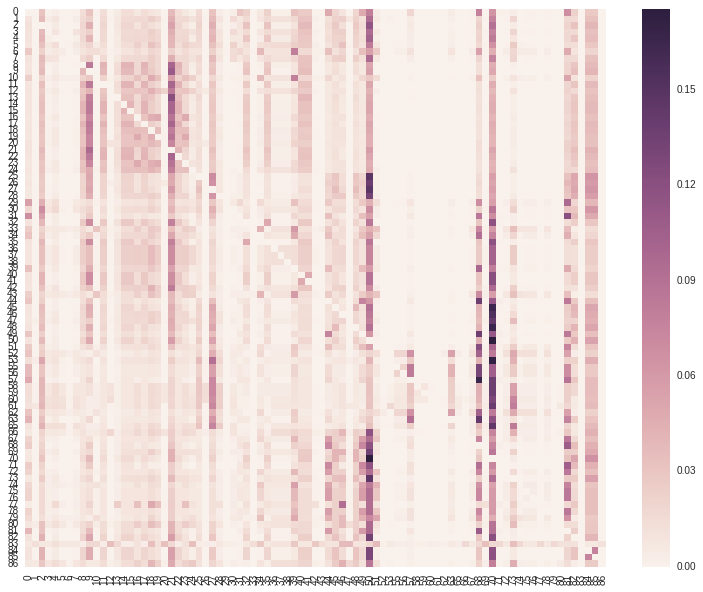

In [76]:
plt.figure(figsize=[13, 10])
#plt.imshow(prob_mat, interpolation='none', cmap=plt.cm.hot)  # OK
#ticks = prob_mat.index
#plt.xticks(np.arange(prob_mat.shape[0]), ticks)
#plt.yticks(np.arange(prob_mat.shape[0]), ticks)
#plt.xlabel('POI ID')
#plt.ylabel('POI ID')
sns.heatmap(poi_transmat)

## 6.9 Visualise Transitions of Specific POIs

Generate KML file to visualise the transitions from a specific POI using edge width and edge transparency to distinguish different transition probabilities.

In [164]:
def gen_kml_transition(fname, poi_id, poi_df, poi_transmat):
    ns = '{http://www.opengis.net/kml/2.2}'

    # scale (linearly) the transition probabilities to [1, 255]: f(x) = a1x + b1
    probs = poi_transmat.loc[poi_id].copy()
    pmax = poi_transmat.loc[poi_id].max()
    probs.loc[poi_id] = 1  # set self-loop to 1 to make np.min() below to get the real minimun prob.
    pmin = poi_transmat.loc[poi_id].min()
    nmin1, nmin2 = 1, 1
    nmax1, nmax2 = 255, 10
    # solve linear equations:
    # nmin = a1 x pmin + b1
    # nmax = a1 x pmax + b1
    a1, b1 = np.dot(np.linalg.pinv(np.array([[pmin, 1], [pmax, 1]])), np.array([nmin1, nmax1])) # control transparency
    a2, b2 = np.dot(np.linalg.pinv(np.array([[pmin, 1], [pmax, 1]])), np.array([nmin2, nmax2])) # control width

    pm_list = []
    stydict = dict()

    # Placemark for edges
    for poi in poi_transmat.columns:
        if poi == poi_id: continue
        prob = probs.loc[poi]
        decimal = int(np.round(a1 * prob + b1)) # scale transition probability to [1, 255]
        hexa = hex(decimal)[2:] + '0' if decimal < 16 else hex(decimal)[2:]  # get rid of prefix '0x'
        color = hexa + '0000ff'  # colors in KML: aabbggrr, aa=00 is fully transparent, transparent red
        width = int(np.round(a2 * prob + b2))
        if color not in stydict:
            stydict[color] = styles.LineStyle(color=color, width=width)
        sid = str(poi_id) + '_' + str(poi)
        ext_dict = {'From poiID': str(poi_id), 'From poiName': poi_df.loc[poi_id, 'Name'], \
                    'To poiID': str(poi), 'To poiName': poi_df.loc[poi, 'Name'], \
                    'Transition Probability': ('%.15f' % prob)}
        ext_data = kml.ExtendedData(elements=[kml.Data(name=x, value=ext_dict[x]) for x in sorted(ext_dict.keys())])
        pm = kml.Placemark(ns, sid, 'Edge_' + sid, description=None, styleUrl='#' + color, extended_data=ext_data)
        pm.geometry = LineString([(poi_df.loc[x, 'Longitude'], poi_df.loc[x, 'Latitude']) for x in [poi_id, poi]])
        pm_list.append(pm)

    # Placemark for POIs: import from csv file directly
        
    k = kml.KML()
    doc = kml.Document(ns, '1', 'Transitions of POI ' + str(poi_id) , description=None, \
                       styles=[styles.Style(id=x, styles=[stydict[x]]) for x in stydict.keys()])
    for pm in pm_list: doc.append(pm)
    k.append(doc)

    # save to file
    kmlstr = k.to_string(prettyprint=True)
    with open(fname, 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write(kmlstr)
        print('write to', fname)

### 6.9.1 The Most Popular POI

**Define the popularity of POI** as the number of distinct users that visited the POI.

In [156]:
most_popular = poi_df['#distinctUsers'].argmax()

In [157]:
#poi_df.loc[most_popular]

In [158]:
#poi_transmat.loc[most_popular]

In [159]:
fname = 'trans_most_popular.kml'
gen_kml_transition(fname, most_popular, poi_df, poi_transmat)

write to trans_most_popular.kml


[Example on Google maps](https://drive.google.com/open?id=18Y61VFEbaekeTZUtchwgTO3fwBo&usp=sharing).

### 6.9.2 The Queen Victoria Market

In [165]:
poi_qvm = poi_df[poi_df['Name'] == 'Queen Victoria Market']
poi_qvm

,Name,Category,Latitude,Longitude,#photos,#visits,#distinctUsers,medianDuration(sec),totalDuration(sec)
poiID,,,,,,,,,
21,Queen Victoria Market,Shopping,-37.806966,144.956693,587,102,65,0.0,249649.0


In [166]:
#poi_transmat.loc[poi_qvm.index[0]]

In [167]:
fname = 'trans_qvm.kml'
gen_kml_transition(fname, poi_qvm.index[0], poi_df, poi_transmat)

write to trans_qvm.kml


[Example on Google maps](https://drive.google.com/open?id=11mJjb9Y6Zb_kjmyV3Hy-MFaMkok&usp=sharing).

### 6.9.3 The University of Melbourne

In [169]:
poi_um = poi_df[poi_df['Name'] == 'University of Melbourne']
poi_um

,Name,Category,Latitude,Longitude,#photos,#visits,#distinctUsers,medianDuration(sec),totalDuration(sec)
poiID,,,,,,,,,
7,University of Melbourne,City precincts,-37.7963,144.9614,213,54,30,0.0,60620.0


In [171]:
#poi_transmat.loc[poi_um.index[0]]

In [172]:
fname = 'trans_um.kml'
gen_kml_transition(fname, poi_um.index[0], poi_df, poi_transmat)

write to trans_um.kml


[Example on Google maps](https://drive.google.com/open?id=1JUkUoUWwpWXI8jhUMuPYA6qirnY&usp=sharing).

### 6.9.4 The Margaret Court Arena

In [173]:
poi_mca = poi_df[poi_df['Name'] == 'Margaret Court Arena']
poi_mca

,Name,Category,Latitude,Longitude,#photos,#visits,#distinctUsers,medianDuration(sec),totalDuration(sec)
poiID,,,,,,,,,
55,Margaret Court Arena,Sports stadiums,-37.821112,144.97741,267,27,25,0.0,77767.0


In [175]:
#poi_transmat.loc[poi_mca.index[0]]

In [176]:
fname = 'trans_mca.kml'
gen_kml_transition(fname, poi_mca.index[0], poi_df, poi_transmat)

write to trans_mca.kml


[Example on Google maps](https://drive.google.com/open?id=1Bi2ayK4VQtdsaE_DAEMK3a4NvJ0&usp=sharing).

## 6.10 Visualise Trajectories that Passing through Specific POIs

Generate KML file for a set of trajectories.

In [200]:
def gen_kml_traj(fname, traj_subdict, poi_df):
    ns = '{http://www.opengis.net/kml/2.2}'
    norm = mpl.colors.Normalize(vmin=1, vmax=len(traj_subdict))
    cmap = mpl.cm.hot
    pmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    pm_list = []
    stydict = dict()
    trajids = sorted(traj_subdict.keys())
    for i in range(len(trajids)):
        traj = traj_subdict[trajids[i]]
        r, g, b, a = pmap.to_rgba(i+1, bytes=True)
        color = '%02x%02x%02x%02x' % (63, b, g, r) # colors in KML: aabbggrr, aa=00 is fully transparent
        if color not in stydict:
            stydict[color] = styles.LineStyle(color=color, width=3)
        for j in range(len(traj)-1):
            poi1 = traj[j]
            poi2 = traj[j+1]
            sid = str(poi1) + '_' + str(poi2)
            ext_dict = {'TrajID': str(trajids[i]), 'Trajectory': str(traj), \
                        'From poiID': str(poi1), 'From poiName': poi_df.loc[poi1, 'Name'], \
                        'To poiID': str(poi2), 'To poiName': poi_df.loc[poi2, 'Name']}
            ext_data = kml.ExtendedData(elements=[kml.Data(name=x, value=ext_dict[x]) for x in sorted(ext_dict.keys())])
            pm = kml.Placemark(ns, sid, 'Edge_' + sid, description=None, styleUrl='#' + color, extended_data=ext_data)
            pm.geometry = LineString([(poi_df.loc[x, 'Longitude'], poi_df.loc[x, 'Latitude']) for x in [poi1, poi2]])
            pm_list.append(pm)

    # Placemark for POIs: import from csv file directly
        
    k = kml.KML()
    doc = kml.Document(ns, '1', 'Visualise %d Trajectories' % len(traj_subdict), description=None, \
                       styles=[styles.Style(id=x, styles=[stydict[x]]) for x in stydict.keys()])
    for pm in pm_list: doc.append(pm)
    k.append(doc)

    # save to file
    kmlstr = k.to_string(prettyprint=True)
    with open(fname, 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write(kmlstr)
        print('write to', fname)

### 6.10.1 The Melbourne Cricket Ground (MCG)

Trajectories (with more than $1$ POIs) that Passing through the Melbourne Cricket Ground (MCG).

In [210]:
poi_mcg = poi_df[poi_df['Name'] == 'Melbourne Cricket Ground (MCG)']
poi_mcg

,Name,Category,Latitude,Longitude,#photos,#visits,#distinctUsers,medianDuration(sec),totalDuration(sec)
poiID,,,,,,,,,
57,Melbourne Cricket Ground (MCG),Sports stadiums,-37.82,144.98333,520,114,75,0.0,442165.0


In [212]:
traj_dict_mcg = dict()
mcg = poi_mcg.index[0]
for tid_ in sorted(traj_dict.keys()):
    traj_ = traj_dict[tid_]
    #if mcg in traj_ and mcg != traj_[0] and mcg != traj_[-1]:
    if mcg in traj_ and len(traj_) > 1:
        traj_dict_mcg[tid_] = traj_
print(len(traj_dict_mcg), 'trajectories pass through Melbourne Cricket Ground (MCG).')

22 trajectories pass through Melbourne Cricket Ground (MCG).


In [213]:
fname = 'traj_pass_mcg.kml'
gen_kml_traj(fname, traj_dict_mcg, poi_df)

write to traj_pass_mcg.kml


[Example on Google maps](https://drive.google.com/open?id=1-51FcjKxdIYl_uAVBYStDpndohk&usp=sharing).

### 6.10.2 The Government House

Trajectories (with more than $1$ POIs) that Passing through the Government House.

In [204]:
poi_gh = poi_df[poi_df['Name'] == 'Government House']
poi_gh

,Name,Category,Latitude,Longitude,#photos,#visits,#distinctUsers,medianDuration(sec),totalDuration(sec)
poiID,,,,,,,,,
33,Government House,Institutions,-37.827939,144.976939,44,10,7,202.0,21258.0


In [208]:
traj_dict_gh = dict()
gh = poi_gh.index[0]
for tid_ in sorted(traj_dict.keys()):
    traj_ = traj_dict[tid_]
    #if gh in traj_ and gh != traj_[0] and gh != traj_[-1]:
    if gh in traj_ and len(traj_) > 1:
        traj_dict_gh[tid_] = traj_
print(len(traj_dict_gh), 'trajectories pass through Government House.')

4 trajectories pass through Government House.


In [209]:
fname = 'traj_pass_gh.kml'
gen_kml_traj(fname, traj_dict_gh, poi_df)

write to traj_pass_gh.kml


[Example on Google maps](https://drive.google.com/open?id=1sAK6evZXcFVyqkwcgLft1DM_qUs&usp=sharing).

# 7. Recommendation Results Comparison & Visualisation

Examples of recommendation results: recommendation based on POI popularity, POI ranking and POI transition matrix, and visualise recommended results on map.

## 7.1 Choose an Example Trajectory

Choose a trajectory of length 4.

In [214]:
traj4s = traj_all[traj_all['trajLen'] == 4]['trajID'].unique()
traj4s

array([  64,  147,  150,  198,  311,  385,  445,  680,  720,  725,  765,
        771,  785,  835,  841,  902,  966, 1042, 1087, 1119, 1134, 1150,
       1170, 1208, 1217, 1233, 1241, 1245, 1265, 1277, 1315, 1562, 1593,
       1769, 1906, 1914, 1921, 1923, 1936, 1984, 1990, 2042, 2101, 2144,
       2220, 2240, 2301, 2340, 2354, 2430, 2572, 2646, 2672, 2690, 2826,
       2912, 3004, 3017, 3091, 3271, 3408, 3505, 3659, 3745, 3775, 3811,
       3888, 3891, 4124, 4130, 4133, 4160, 4183, 4198, 4202, 4204, 4205,
       4245, 4316, 4368, 4372, 4376, 4396, 4440, 4450, 4702, 4710, 4742,
       4832, 4842, 4887, 4906, 4922, 5064, 5067])

In [215]:
#for tid in traj4s:
#    gen_kml(tid, traj_all, poi_df)

After looking at many of these trajectories on map, we choose trajectory 680 to illustrate.

In [217]:
tid = 680
traj = extract_traj(tid, traj_all)
print('REAL:', traj)

REAL: [76, 81, 71, 68]


In [230]:
traj_dict_rec = {'REAL_' + str(tid): traj}

In [218]:
start = traj[0]
end = traj[-1]
length = len(traj)

## 7.2 Recommendation by POI Popularity

Recommend trajectory based on POI popularity only.

In [220]:
poi_df.sort_values(by='#distinctUsers', ascending=False, inplace=True)
rec_pop = [start] + [x for x in poi_df.index.tolist() if x not in {start, end}][:length-2] + [end]
print('REC_POP:', rec_pop)

REC_POP: [76, 71, 82, 68]


In [231]:
tid_rec = 'REC_POP'
traj_dict_rec[tid_rec] = rec_pop

## 7.3 Recommendation by POI Rankings

Recommend trajectory based on the ranking of POIs using rankSVM.

In [222]:
trajid_list_train = list(set(trajid_set_all) - {tid})
poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)

In [223]:
train_df = gen_train_df(trajid_list_train, traj_dict, poi_info) # POI feature based ranking
ranksvm = RankSVM(ranksvm_dir, useLinear=True)
ranksvm.train(train_df, cost=RANK_C)
test_df = gen_test_df(start, end, length, poi_info)
rank_df = ranksvm.predict(test_df)
rank_df.sort_values(by='rank', ascending=False, inplace=True)
rec_rank = [start] + [x for x in rank_df.index.tolist() if x not in {start, end}][:length-2] + [end]
print('REC_RANK:', rec_rank)

REC_RANK: [76, 71, 82, 68]


In [232]:
tid_rec = 'REC_RANK'
traj_dict_rec[tid_rec] = rec_rank

## 7.4 Recommendation by Transition Probabilities

Use dynamic programming to find a possibly non-simple path, i.e., walk.

In [225]:
def find_path(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    # with sub-tours in trajectory, this is not the case any more, but it is nonsense to recommend such trajectories
    assert(2 < L <= V.index.shape[0])  
    if withNodeWeight == True:
        assert(0 < alpha < 1)
    beta = 1 - alpha
    
    A = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.float), columns=V.index, index=np.arange(2, L+1))
    B = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.int),   columns=V.index, index=np.arange(2, L+1))
    A += np.inf
    for v in V.index:
        if v != ps:
            if withNodeWeight == True:
                A.loc[2, v] = alpha * (V.loc[ps, 'weight'] + V.loc[v, 'weight']) + beta * E.loc[ps, v]  # ps--v
            else:
                A.loc[2, v] = E.loc[ps, v]  # ps--v
            B.loc[2, v] = ps
    
    for l in range(3, L+1):
        for v in V.index:
            if withNodeWeight == True: # ps-~-v1---v
                values = [A.loc[l-1, v1] + alpha * V.loc[v, 'weight'] + beta * E.loc[v1, v] for v1 in V.index]
            else:
                values = [A.loc[l-1, v1] + E.loc[v1, v] for v1 in V.index]  # ps-~-v1---v   
            
            minix = np.argmin(values)
            A.loc[l, v] = values[minix]
            B.loc[l, v] = V.index[minix]
            
    path = [pe]
    v = path[-1]
    l = L
    #while v != ps:  #incorrect if 'ps' happens to appear in the middle of a path
    while l >= 2:
        path.append(B.loc[l, v])
        v = path[-1]
        l -= 1
    path.reverse()
    return path

Use integer linear programming (ILP) to find a simple path.

In [226]:
def find_path_ILP(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    assert(2 < L <= V.index.shape[0])
    if withNodeWeight == True:
        assert(0 < alpha < 1)
    beta = 1 - alpha
    
    p0 = str(ps); pN = str(pe); N = V.index.shape[0]
    
    # deal with np.inf which will cause ILP solver failure
    Edges = E.copy()
    INF = 1e6
    for p in Edges.index:
        Edges.loc[p, p] = INF 
    maxL = np.max(Edges.values.flatten())
    if maxL > INF:
        for p in Edges.index:
            Edges.loc[p, p] = maxL    
    
    # REF: pythonhosted.org/PuLP/index.html
    pois = [str(p) for p in V.index] # create a string list for each POI
    pb = pulp.LpProblem('MostLikelyTraj', pulp.LpMinimize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)
    
    # add objective
    objlist = []
    if withNodeWeight == True:
        objlist.append(alpha * V.loc[int(p0), 'weight'])
    for pi in [x for x in pois if x != pN]:     # from
        for pj in [y for y in pois if y != p0]: # to
            if withNodeWeight == True:
                objlist.append(visit_vars[pi][pj] * (alpha*V.loc[int(pj), 'weight'] + beta*Edges.loc[int(pi), int(pj)]))
            else:
                objlist.append(visit_vars[pi][pj] * Edges.loc[int(pi), int(pj)])
    pb += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    pb += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAt_p0'
    pb += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAt_pN'
    if p0 != pN:
        pb += pulp.lpSum([visit_vars[pi][p0] for pi in pois]) == 0, 'NoIncoming_p0'
        pb += pulp.lpSum([visit_vars[pN][pj] for pj in pois]) == 0, 'NoOutgoing_pN'
    pb += pulp.lpSum([visit_vars[pi][pj] for pi in pois if pi != pN for pj in pois if pj != p0]) == L-1, 'Length'
    for pk in [x for x in pois if x not in {p0, pN}]:
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
              pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'ConnectedAt_' + pk
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, 'Enter_' + pk + '_AtMostOnce'
        pb += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, 'Leave_' + pk + '_AtMostOnce'
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            pb += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + pi + '_' + pj
    #pb.writeLP("traj_tmp.lp")
    # solve problem
    pb.solve(pulp.PULP_CBC_CMD(options=['-threads', '6', '-strategy', '1', '-maxIt', '2000000'])) # CBC
    #gurobi_options = [('TimeLimit', '7200'), ('Threads', '8'), ('NodefileStart', '0.9'), ('Cuts', '2')]
    #pb.solve(pulp.GUROBI_CMD(options=gurobi_options)) # GUROBI
    visit_mat = pd.DataFrame(data=np.zeros((len(pois), len(pois)), dtype=np.float), index=pois, columns=pois)
    for pi in pois:
        for pj in pois: visit_mat.loc[pi, pj] = visit_vars[pi][pj].varValue

    # build the recommended trajectory
    recseq = [p0]
    while True:
        pi = recseq[-1]
        pj = visit_mat.loc[pi].idxmax()
        assert(round(visit_mat.loc[pi, pj]) == 1)
        recseq.append(pj); 
        #print(recseq); sys.stdout.flush()
        if pj == pN: return [int(x) for x in recseq]

In [227]:
poi_logtransmat = np.log(gen_poi_transmat(trajid_list_train, set(poi_info.index), traj_dict, poi_info))
nodes = poi_info.copy()
edges = poi_logtransmat.copy()
edges = -1 * edges  # edge weight is negative log of transition probability
rec_dp = find_path(nodes, edges, start, end, length) # DP
rec_ilp = find_path_ILP(nodes, edges, start, end, length) # ILP
print('REC_DP:', rec_dp)
print('REC_ILP:', rec_ilp)

REC_DP: [76, 68, 81, 68]
REC_ILP: [76, 81, 44, 68]


In [238]:
tid_rec = 'REC_DP'
traj_dict_rec[tid_rec] = rec_dp
tid_rec = 'REC_ILP'
traj_dict_rec[tid_rec] = rec_ilp

In [239]:
traj_dict_rec

{'REAL_680': [76, 81, 71, 68],
 'REC_DP': [76, 68, 81, 68],
 'REC_ILP': [76, 81, 44, 68],
 'REC_POP': [76, 71, 82, 68],
 'REC_RANK': [76, 71, 82, 68]}

In [235]:
fname = 'traj_rec.kml'
gen_kml_traj(fname, traj_dict_rec, poi_df)

write to traj_rec.kml


[Example on Google maps](https://drive.google.com/open?id=1bopkMg7ie9pkCM6zFD2S9pSeGsk&usp=sharing), 
- the light blue edges represent the real trajectory, 
- green edges represent the recommended trajectories based on POI popularity and POI rankings (the recommendations are the same), 
- the red edges represent the recommended trajectories based on POI transition probabilities using Viterbi algorithm.
- the purple edges represent the recommended trajectories based on POI transition probabilities using ILP.

# 8. Disclaimer

## 8.1 Problems of Trajectory Construction

- Problems of mapping photos to POIs according to their distance, i.e., $200$ meters.
- Problems of split consecutive POI visits by $8$ hours.
- Problems of extract trajectories from a sequence of POI visits such that no loops/subtours exist.

## 8.2 Example of Terrible Trajectories

Choose the trajectory with the maximum number of POIs.

In [293]:
tid = traj_all.loc[traj_all['trajLen'].idxmax(), 'trajID']
tid

1203

In [294]:
traj1 = extract_traj_withloop(tid, visits)
print(traj1, 'length:', len(traj1))

[42, 32, 9, 35, 8, 17, 13, 15, 82, 50, 71, 81, 44, 45, 14, 9, 32, 85, 1, 53, 85, 27, 25] length: 23


In [295]:
traj2 = extract_traj(tid, traj_all)
print(traj2, 'length:', len(traj2))

[42, 32, 9, 35, 8, 17, 13, 15, 82, 50, 71, 81, 44, 45, 14, 85, 1, 53, 27, 25] length: 20


Extract the sequence of photos associated with this trajectory.

In [296]:
photo_df = pd.read_csv(fphotos, skipinitialspace=True)
photo_df.set_index('Photo_ID', inplace=True)
#photo_df.head()

In [297]:
photo_traj = visits[visits['trajID'] == tid]['photoID'].values
photo_tdf = photo_df.loc[photo_traj].copy()

In [298]:
photo_tdf.drop(photo_tdf.columns[-1], axis=1, inplace=True)
photo_tdf.drop('Accuracy', axis=1, inplace=True)
photo_tdf.sort_values(by='Timestamp', ascending=True, inplace=True)

In [299]:
visit_df = visits.copy()
visit_df.set_index('photoID', inplace=True)

In [300]:
photo_tdf['poiID'] = visit_df.loc[photo_tdf.index, 'poiID']
photo_tdf['poiName'] = poi_df.loc[photo_tdf['poiID'].values, 'Name'].values
photo_tdf.head()

,User_ID,Timestamp,Longitude,Latitude,URL,poiID,poiName
Photo_ID,,,,,,,
2219377707,30342939@N00,2007-11-24 07:10:57.0,144.958151,-37.815776,http://www.flickr.com/photos/30342939@N00/2219...,42,Supreme Court of Victoria
2220174790,30342939@N00,2007-11-24 07:12:14.0,144.958151,-37.815776,http://www.flickr.com/photos/30342939@N00/2220...,42,Supreme Court of Victoria
2220179282,30342939@N00,2007-11-24 07:18:07.0,144.961606,-37.814793,http://www.flickr.com/photos/30342939@N00/2220...,32,General Post Office
2220183668,30342939@N00,2007-11-24 07:24:51.0,144.962883,-37.813360,http://www.flickr.com/photos/30342939@N00/2220...,32,General Post Office
2220186382,30342939@N00,2007-11-24 07:26:10.0,144.962947,-37.813496,http://www.flickr.com/photos/30342939@N00/2220...,32,General Post Office


Save photos dataframe to CSV file.

In [301]:
fname = 'photo_traj_df.csv'
photo_tdf.to_csv(fname, index=True)

Generate KML file with edges between consecutive photos.

In [309]:
fname = 'traj_photo_seq.kml'
ns = '{http://www.opengis.net/kml/2.2}'
k = kml.KML()
styid = 'edge_style' # colors in KML: aabbggrr, aa=00 is fully transparent
sty_edge = styles.Style(id=styid, styles=[styles.LineStyle(color='3fff0000', width=2)])
doc = kml.Document(ns, '1', 'Photo sequence of trajectory %d' % tid, description=None, styles=[sty_edge])
k.append(doc)
for j in range(photo_tdf.shape[0]-1):
    p1, p2 = photo_tdf.index[j], photo_tdf.index[j+1]
    poi1, poi2 = visit_df.loc[p1, 'poiID'], visit_df.loc[p2, 'poiID']
    sid = 'Photo_POI%d_POI%d' % (poi1, poi2)
    ext_dict = {'From Photo': str(p1), 'To Photo': str(p2)}
    ext_data = kml.ExtendedData(elements=[kml.Data(name=x, value=ext_dict[x]) for x in sorted(ext_dict.keys())])
    pm = kml.Placemark(ns, sid, sid, description=None, styleUrl='#' + styid, extended_data=ext_data)
    pm.geometry = LineString([(photo_df.loc[x, 'Longitude'], photo_df.loc[x, 'Latitude']) for x in [p1, p2]])
    doc.append(pm)

# Placemark for photos: import from csv file directly

# save to file
kmlstr = k.to_string(prettyprint=True)
with open(fname, 'w') as f:
    f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    f.write(kmlstr)
    print('write to', fname)

write to traj_photo_seq.kml


And the trajectory extracted.

In [310]:
fname = 'traj_terrible.kml'
gen_kml_traj(fname, {tid:traj2}, poi_df)

write to traj_terrible.kml


[Example on Google maps](https://drive.google.com/open?id=1FwWWgkCH53X7nanl-lZ_cH58PeI&usp=sharing).

## 8.3 Limitations of Google Maps and Nationalmaps

Some limitations of Google maps and Nationalmaps I encountered during this work:
- Google Maps rendering inconsistently with the scale factor of icons in styles, no matter using default icon or custom icons.
  - Scale factor of icons was ignored if it was greater than 1.
  - Icons rendered correctly if the scale factor is less than 1.
  - For two icons, if the scale factor of one icon is less than 1, and the other is greater than 1, the two icons were rendered using the same style with the smaller scale factor.
- Nationalmaps was not as robust as Google maps and didn't support custom icons.
  - Nationalmaps support different size of marker icons specified by the scale factor, but I didn't find a way to change the default icon.
  - Nationalmaps didn't support custom icons, once used, the POIs will be rendered with no icons, only names.
  - Nationalmaps didn't render some KML files that rendered correctly by Google maps (on Chrome/Chromium/Firefox)
  - Nationalmaps rendered the edge of trajectory correctly but not all POIs were rendered.  